In [1]:
#Bibliotecas
import random as rn
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing

In [2]:
#Gerar um novo modelo
new_model = True

In [3]:
#Carrega os dados
data_raw = pd.read_csv('Consumo_cerveja.csv', sep=';')

data = data_raw.iloc[:, -1].values

#Substitui as virgulas por pontos
padrao = r'"(.*?)"'
def substituir_virgula(match):
    return match.group().replace(',', '.')

#Trata os dados
data_ = []
for i in range(len(data)):
    data[i] = re.sub(padrao, substituir_virgula, data[i])
    data[i] = data[i].replace('"', '')
    data[i] = data[i].split(',')
    data_.append(data[i])

data = np.array(data_)

#Armazena as datas em um vetor separado
date = data[:, 0]
date = pd.to_datetime(date)
date = date.dayofweek

#Remove a coluna de datas
data = np.delete(data, 0, 1)
data = data.astype(float)

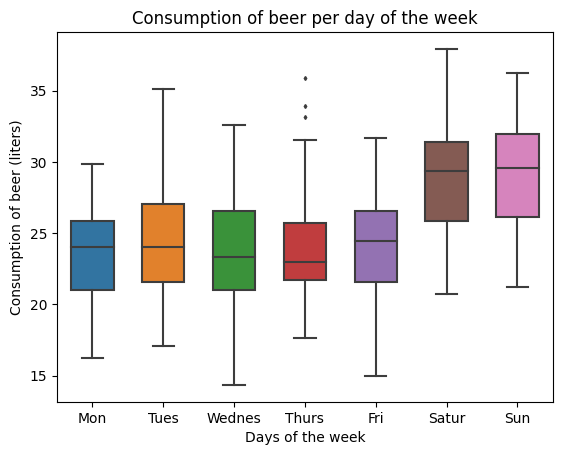

In [4]:
#Plota o consumo de cerveja por dia da semana
days = ["Mon", "Tues", "Wednes", "Thurs", "Fri", "Satur", "Sun"]
sns.boxplot(x=date, y=data[:, 5],width=0.6, fliersize=2)
plt.xticks(range(len(days)), days)
plt.xlabel("Days of the week")
plt.ylabel("Consumption of beer (liters)")
plt.title("Consumption of beer per day of the week")
plt.show()

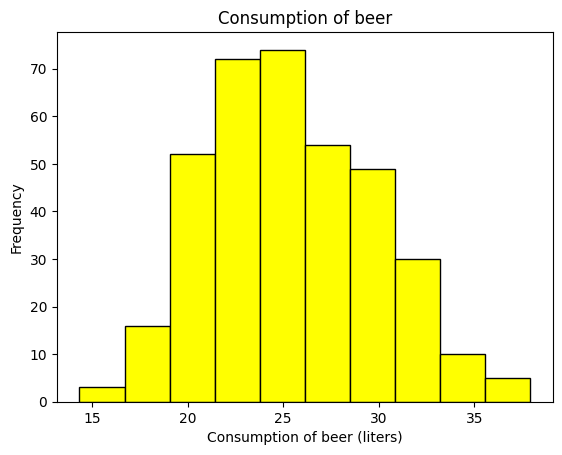

In [5]:
#Plota a frequencia de consumo de cerveja
plt.hist(data[:, 5],color='yellow', edgecolor='black')
plt.xlabel("Consumption of beer (liters)")
plt.ylabel("Frequency")
plt.title("Consumption of beer")
plt.show()

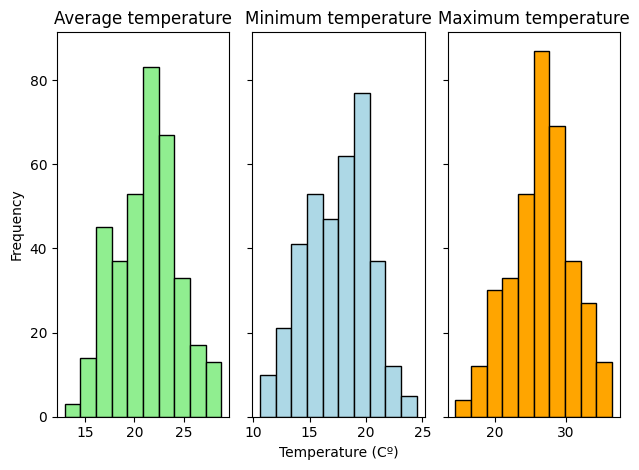

In [6]:
#Plota a frequencia de temperatura media, minima e maxima
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

axs[0].hist(data[:, 0],color='lightGreen', edgecolor='black')
axs[0].set_title('Average temperature')
axs[0].set_ylabel('Frequency')

axs[1].hist(data[:, 1],color='lightBlue', edgecolor='black')
axs[1].set_title('Minimum temperature')
axs[1].set_xlabel('Temperature (Cº)')

axs[2].hist(data[:, 2],color='orange', edgecolor='black')
axs[2].set_title('Maximum temperature')

plt.show()


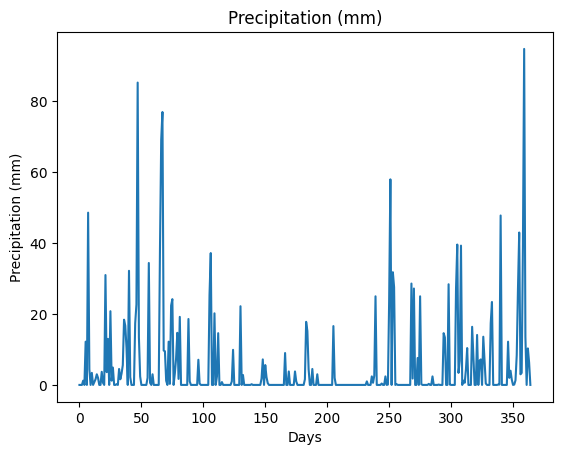

In [7]:
#Plota a precipitacao ao longo do ano
plt.plot(data[:,3])
plt.title('Precipitation (mm)')
plt.xlabel('Days')
plt.ylabel('Precipitation (mm)')
plt.show()

In [8]:
#Padoroniza os dados entre 0 e 1
min_max_scaler = preprocessing.MinMaxScaler()

data[:,0] = min_max_scaler.fit_transform(data[:,0].reshape(-1,1)).reshape(-1)
data[:,1] = min_max_scaler.fit_transform(data[:,1].reshape(-1,1)).reshape(-1)
data[:,2] = min_max_scaler.fit_transform(data[:,2].reshape(-1,1)).reshape(-1)
data[:,3] = min_max_scaler.fit_transform(data[:,3].reshape(-1,1)).reshape(-1)
data[:,4] = min_max_scaler.fit_transform(data[:,4].reshape(-1,1)).reshape(-1)
data[:,5] = min_max_scaler.fit_transform(data[:,5].reshape(-1,1)).reshape(-1)


In [9]:
#Separa os dados de treino e teste
train = np.array(rn.sample(list(data), int(len(data)*0.8)))
test = np.array([x for x in data if x.tolist() not in train.tolist()])

x_train = np.array(train[:,0:4])
y_train = np.array(train[:,5])

x_test = np.array(test[:,0:4])
y_test = np.array(test[:,5])

In [10]:
#Cria o modelo
act_function = 'tanh' 
drop = 0.1 
#initializer = tensorflow.keras.initializers.LecunNormal() #testar com inicializador padrao
initializer = tensorflow.keras.initializers.GlorotNormal()
inputs = Input(shape = (x_train.shape[1]), dtype='float32')

layer1 = Dense(16, activation=act_function, kernel_initializer=initializer)(inputs)
layer1 = Dropout(drop)(layer1)

layer2 = Dense(32, activation=act_function, kernel_initializer=initializer)(layer1)
layer2 = Dropout(drop)(layer2)

layer3 = Dense(16, activation=act_function, kernel_initializer=initializer)(layer2)
layer3 = Dropout(drop)(layer3)


outputs = Dense(1, activation=act_function, kernel_initializer=initializer)(layer3)

dnn_beer = Model(inputs, outputs)
dnn_beer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0     

c:\Users\sandy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [11]:
#Treina o modelo
if (new_model == True):
    
    tensorflow.keras.backend.set_epsilon(1)
    opt = (learning_rate=0.0000Adam1) #diminiur a taxa de aprendizado um pouco: 0.0001
    
    dnn_beer.compile(optimizer=opt, loss='mean_squared_error')
    
    es = EarlyStopping(monitor='loss', mode='min', patience=200)

    history = dnn_beer.fit(x_train, y_train, 
                                validation_split= 0.1 ,
                                epochs=1000, 
                                verbose=1, 
                                callbacks=[es], 
                                batch_size=4, #recomendo usar 4
                                shuffle=False)
    
    np.save('models/history_model.npy', history.history)
    dnn_beer.save('models/dnn_beer.h5')
else:
    dnn_beer = load_model('models/dnn_beer.h5')

Epoch 1/1000
66/66 [==============================] - 1s 5ms/step - loss: 0.2044 - val_loss: 0.1721
Epoch 2/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.1648 - val_loss: 0.1498
Epoch 3/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.1471 - val_loss: 0.1298
Epoch 4/1000
66/66 [==============================] - 0s 3ms/step - loss: 0.1342 - val_loss: 0.1123
Epoch 5/1000
66/66 [==============================] - 0s 3ms/step - loss: 0.1102 - val_loss: 0.0983
Epoch 6/1000
66/66 [==============================] - 0s 3ms/step - loss: 0.1042 - val_loss: 0.0864
Epoch 7/1000
66/66 [==============================] - 0s 2ms/step - loss: 0.0943 - val_loss: 0.0761
Epoch 8/1000
66/66 [==============================] - 0s 3ms/step - loss: 0.0941 - val_loss: 0.0667
Epoch 9/1000
66/66 [==============================] - 0s 3ms/step - loss: 0.0707 - val_loss: 0.0598
Epoch 10/1000
66/66 [==============================] - 0s 3ms/step - loss: 0.0873 - val_loss: 0.0532

{'loss': [0.20443060994148254, 0.1648450344800949, 0.147114098072052, 0.134162038564682, 0.11016661673784256, 0.10417493432760239, 0.09425295144319534, 0.09407654404640198, 0.07069773972034454, 0.08725350350141525, 0.0688217505812645, 0.06068243458867073, 0.061393387615680695, 0.0529012605547905, 0.04457582160830498, 0.04969916492700577, 0.05606270954012871, 0.03954579681158066, 0.04737749695777893, 0.043248582631349564, 0.03589276224374771, 0.040579184889793396, 0.034877240657806396, 0.04495904594659805, 0.03524649515748024, 0.03668169677257538, 0.03872145712375641, 0.04199922829866409, 0.036017220467329025, 0.035416074097156525, 0.03928481042385101, 0.03363931179046631, 0.04145326837897301, 0.0352867916226387, 0.0379863940179348, 0.03864096477627754, 0.03537435457110405, 0.03420523554086685, 0.03370378538966179, 0.032419584691524506, 0.03668375685811043, 0.03769639879465103, 0.03738392889499664, 0.03692883625626564, 0.032017819583415985, 0.03400631621479988, 0.03170633688569069, 0.03

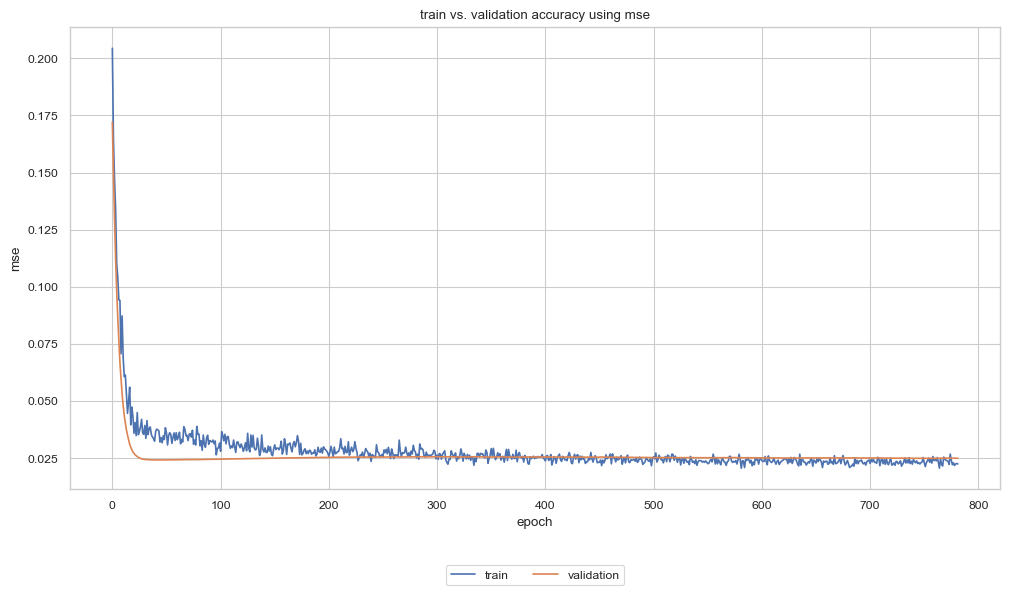

In [12]:
#Plota o historico de treino
history=np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

print (history)

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'mse'

fig = plt.figure()

plt.plot(train_metric, label='train'),
plt.plot(valid_metric, label='validation')
plt.ylabel(name_metric)
plt.xlabel('epoch')
plt.title(f'train vs. validation accuracy using {name_metric}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

In [13]:
#Calcula o erro medio absoluto
y_hat = dnn_beer.predict(x_test)

#voltar para a escala litros
y_test = min_max_scaler.inverse_transform(y_test.reshape(-1,1))
y_hat = min_max_scaler.inverse_transform(y_hat.reshape(-1,1))

3/3 [==============================] - 0s 2ms/step


In [14]:
error = y_test - y_hat
error = np.sqrt(error**2)
mean_error = np.mean(error)
print (f'DNN error: {mean_error:.2f}') #erro previsto em litros para mais ou para menos
    

DNN error: 2.61
